<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [ ]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos')

Estou rodando no Colab (S/N)?
s
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [1]:
#bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import matplotlib.gridspec as gridspec
from ast import literal_eval

#pré processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#modelos recorrentes Keras
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping

#bibliotecas necessárias para gridsearch
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

#modelo sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

#métricas de avaliação dos modelos.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

### Importação dos dados

In [2]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Tratamento inicial dos dados
* Mediana dos dias 
* Unificação dos datasets 
* Separação treino e teste final

In [3]:
# Unificação dos datasets #####

#calculando a mediana dos dados
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()

#Unificando os datasets 
data_health['id']=data_health.index
data_health.head()
data_all = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')


### Separação treino teste
np.random.seed(123)
np.random.randint(0,2,10)
test = np.random.choice(np.unique(data_health.COD_AENV),2)

# Treino 
data  = data_all[data_all.COD_AENV != test[0]][data_all.COD_AENV != test[1]]
print("Aviões usados para teste: ", test)


## Teste final
data_test = data_all[(data_all.COD_AENV == test[0]) | (data_all.COD_AENV == test[1])]
print("Aviões usados para validação k-fold: ", np.unique(data_health.COD_AENV))

Aviões usados para teste:  [9834 9747]
Aviões usados para validação k-fold:  [1011 9486 9526 9636 9664 9678 9747 9770 9793 9834]


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Vizualização das séries

In [ ]:
#visualizando todas as falhas de todas as aeronaves
px.line(data, x='DT_PROC', y='VLR_DESG', color='COD_AENV', line_dash='COD_FALH')


In [ ]:
#visualizando de todas as características por aeronave e cod_falha
px.line(data, x='DT_PROC', y='VLR_CARAC', color='COD_AENV', line_dash='COD_FALH')

##Detecção de quebras

###Funções implementadas

In [20]:
def serie_breaks (desgaste,cod_falh):
  if cod_falh ==35:
    dist =20
  else:
    dist =3
  quebras = []
  for i in range(0,len(desgaste)-1):
    if abs(desgaste[i]-desgaste[i+1])>dist:
      quebras.append(i)
  quebras = np.array(quebras)

  return quebras


#aplica filtro de média móvel
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') /w
  
  return desgaste_filt

#retorna os índices em que ocorrem as quebras
def quebra_filt(desgaste,dist):
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      

  quebras = np.array(quebras)

  return quebras

#verifica se os trechos atendem os requisitos de dias necessários
def desg_uti(desgaste,quebras,look_back):

  des_uti = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if i in quebras:
      if len(desgaste[a:i])>=n_pontos:
        des_uti = des_uti + desgaste[a:i+1].tolist()
      else:
        des_uti = des_uti + len(desgaste[a:i+1])*[-2]
        #print(a)
      a = i+1
  if len(desgaste[a:])>=n_pontos:
    des_uti = des_uti + desgaste[a:].tolist()
  else:
    des_uti = des_uti + len(desgaste[a:])*[-2]

  return des_uti  

#plota as séries e suas quebras
def func_plot (desgaste,quebras,aeronave,des_uti,lim):
  plt.figure(figsize=(15, 2),dpi=300)
  #plt.plot(carac,'xr',label='Carac')
  plt.plot(desgaste,'ok',label='Desgaste real', markersize=2)
  plt.plot(des_uti, 'or',label='Desgaste utilizado', markersize=2)
  plt.legend()
  plt.title(aeronave)
  plt.grid()
  plt.ylim([lim[0],lim[1]])
  plt.vlines(quebras, 0, 100)

#função principal para identificação e visualização para todas as aeronaves.
def descont(data,cod_falha,look_back,lim):
  for aeronave in np.unique(data.COD_AENV):
    aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
    desgaste = aero_data.VLR_DESG.values
    quebra = serie_breaks(desgaste,cod_falha)
    des_uti = desg_uti(desgaste,quebra,look_back)
    func_plot(desgaste,quebra,aeronave,des_uti,lim)

### Visualização das quebras por falha

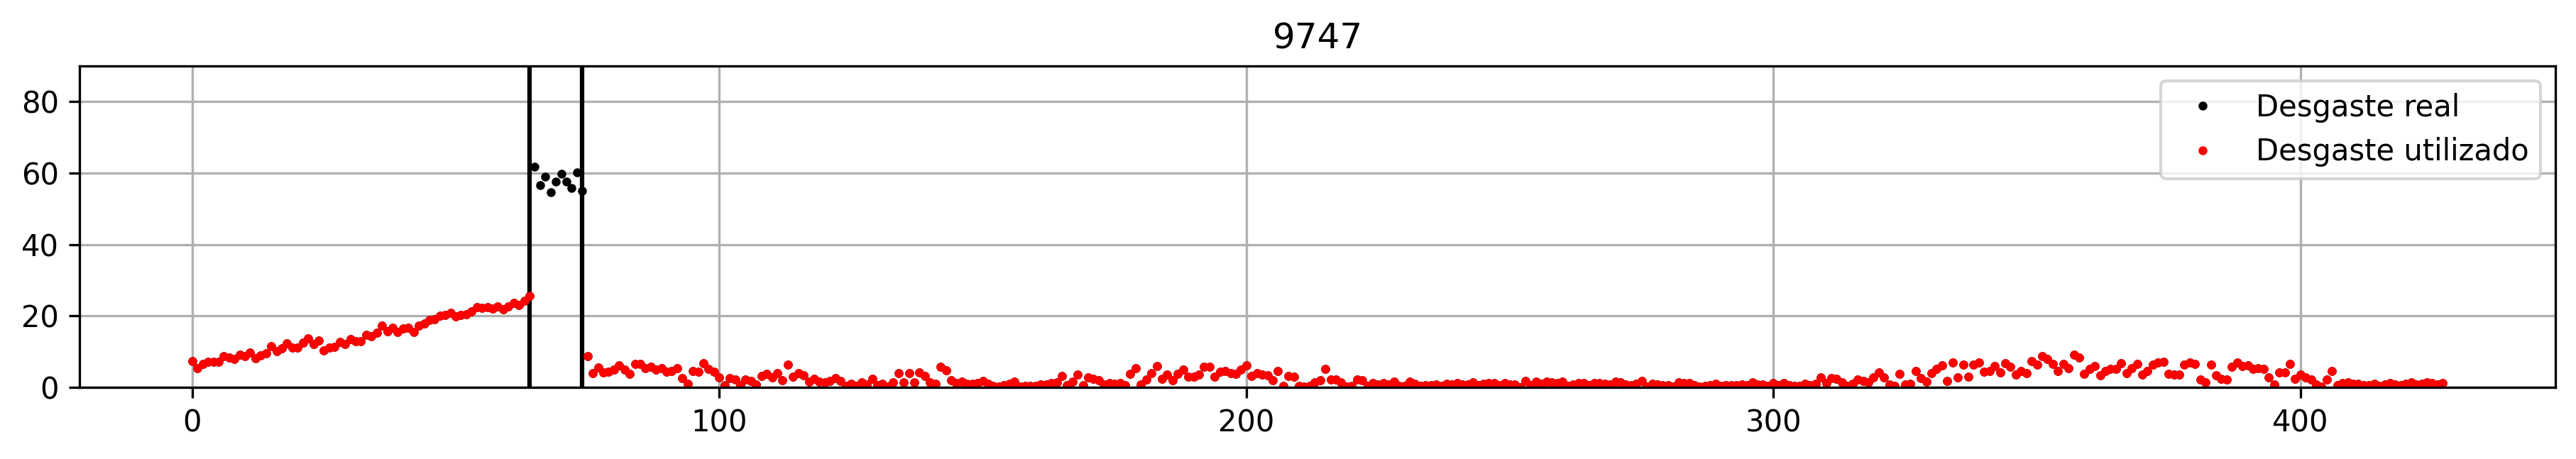

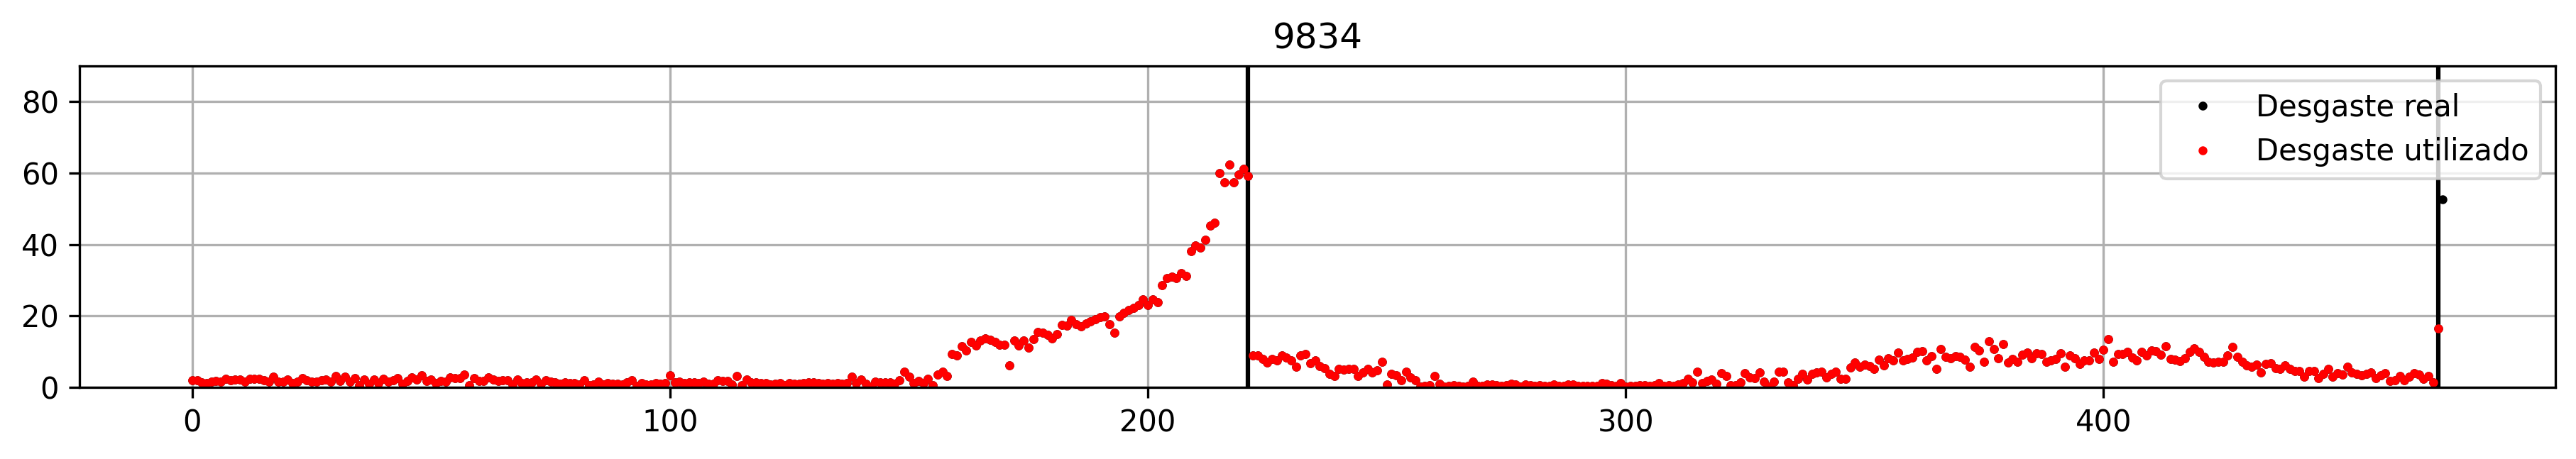

In [21]:
# dist = 10   #distancia de pontos para considerar um quebra
cod_falha = 35 #1, 23, 24 e 35    #Definir qual falha deseja visualizar
look_back=10    #dias usados para predição
lim = [0,90]    #Limites do eixo y
aeronaves = np.unique(data_test.COD_AENV)
descont(data_test,cod_falha,look_back,lim)

## Separação das amostras

In [ ]:
#aplica filtro de média móvel
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') / w
  
  return desgaste_filt

#retorna os índices em que ocorrem as quebras
def discontinuity_filt(desgaste):
  dist = 10
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      
  quebras = np.array(quebras)

  return quebras

#Transforma o banco de dados em instâncias/amostras de acordo com o janela de tempo utilizada
def get_samples (data, cod_falha, look_back):
  samples=[]
  samples_day=[]
  n = look_back+10 #Tamanho (Dias) necessário da amostra

  for aircraft in np.unique(data.COD_AENV):
      air_data = data[(data.COD_AENV==aircraft)  & (data.COD_FALH==cod_falha)] #filtrando por aeronave e cod_falh
      degradation = air_data.VLR_DESG.values
      day = air_data.DT_PROC.values
      discontinuities = discontinuity_filt(degradation) #identificando as descontinuidades
      discontinuities=np.append(discontinuities, len(degradation)-1) #insere o fim do trecho
      init=0
      for i in range(0,len(discontinuities)): 
        interval_break=degradation[init:discontinuities[i]+1] #intervalo entre duas quebras
        interval_days = day[init:discontinuities[i]+1] #dias correspondentes ao intervalo 
        init=discontinuities[i]+1
        if len(interval_break)>=look_back+10: #verifica se os intervalos possuem a quantidade minima de valores
            for i in range(0,len(interval_break)-n+1): #separa os intervalos em amostras
              sample = interval_break[i:i+n].tolist() #uma amostra com n valores
              sample_day = interval_days[i:i+n].tolist() #dias correspondentes à amostra
              sample_day.append(aircraft)
              sample.append(aircraft)
              samples.append(sample)
              samples_day.append(sample_day)
      
  samples = np.array(samples)
  samples_day = np.array(samples_day)
  return  samples, samples_day 


#Normalização das amostras
def normalize_samples(samples, norm_method):
  if norm_method=="MM(-1,1)":
    scaler = MinMaxScaler(feature_range=(-1, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="MM(0,1)":
    scaler = MinMaxScaler(feature_range=(0, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="Zscore":
    scaler = StandardScaler()
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  else:
    return samples


#Separa as amostras em em X,Y e treino, teste
def split_train_test (samples, air_test, look_back, norm_method=False, reshape=True): 
  data_train = samples[samples[:, look_back+10] != air_test][:, 0:look_back+10] #dados de treino
  #seperação de x e y
  x_train = data_train[:,0:look_back]
  y_train = data_train[:,look_back+9]

  if air_test==False:
    if norm_method != False:
      x_train, x_scaler = normalize_samples(x_train, norm_method)
      y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)

      if reshape==True:
        x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
        y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
        return x_train, y_train, y_scaler, x_scaler

      else:
        return x_train, y_train, y_scaler, x_scaler
  
    return x_train, y_train

  data_test = samples[samples[:, look_back+10] == air_test][:, 0:look_back+10] #dados de teste
  #seperação de x e y
  x_test = data_test[:,0:look_back]
  y_test = data_test[:,look_back+9]

  #normalização de x e y
  x_train, x_scaler = normalize_samples(x_train, norm_method)
  x_test = x_scaler.transform(x_test)
  y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)
  y_test = y_scaler.transform(y_test.reshape(-1, 1))

  #reshape para treinar os modelos recorrentes
  if reshape==True:
      x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
      y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
      x_test  = np.reshape(x_test , (x_test.shape[0], 1, x_test[0].shape[0]))
      y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  #retorna os scalers para reverter a normalização
  return x_train, y_train, x_test, y_test, y_scaler, x_scaler 


### Visualização das amostras


Text(0, 0.5, 'Desgaste (%)')

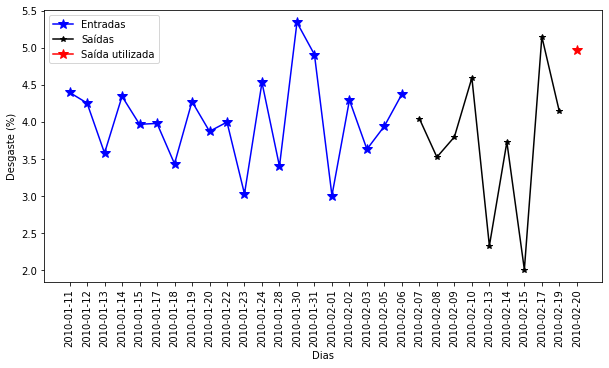

In [ ]:
cod_falha = 35
look_back = 20

samples, samples_day = get_samples (data, cod_falha, look_back)

x=samples[:,0:look_back] #Entradas
y_used=samples[:,look_back+9] #Saída utilizada
y=samples[:,look_back:look_back+9] #Saídas não utilizadas

x_day=samples_day[:,0:look_back] #Dias das entradas
y_used_day=samples_day[:,look_back+9] #Dia da saída utilizada
y_day=samples_day[:,look_back:look_back+9] #Dias das saídas não utilizadas

#Visualizando uma amostra
plt.figure(figsize=(10,5))
plt.plot(x_day[0], x[0], "b-*", label="Entradas", markersize=10)
plt.xticks(rotation=90)
plt.plot(y_day[0], y[0], "k-*", label="Saídas")
plt.plot(y_used_day[0], y_used[0], "r-*", label="Saída utilizada", markersize=10)
plt.legend()
plt.xlabel("Dias")
plt.ylabel("Desgaste (%)")

In [ ]:
#Visualizando os métodos de normalização
air_test=1011
look_back = 20
print("Método",  "     Min", "                 Máx", "                    Média", "            Desvio")
for norm_method in ["MM(-1,1)", "MM(0,1)", "Zscore"]:
  x_train, y_train, x_test, y_test, scaler, _ = split_train_test (samples, air_test, look_back, norm_method, reshape = False)
  print(norm_method,np.min(x_train[:,0]),np.max(x_train[:,0]),np.mean(x_train[:,0]),np.std(x_train[:,0]),'\n')


Método      Min                  Máx                     Média             Desvio
MM(-1,1) -0.9999999999999999 1.0000000000000002 -0.7472048319397064 0.3642033481852817 

MM(0,1) 0.0 1.0 0.12639758403014675 0.18210167409264086 

Zscore -0.6941044592805032 4.797333249805405 -6.620697704253845e-16 1.0000000000000002 



##GridSearch

### Funções implementadas

In [ ]:
#Retorna todas as métricas calculadas
def metrics(y_true,y_pred):
  mse  = mean_squared_error(y_true, y_pred) 
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  max_e = max_error(y_true, y_pred) 
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return([rmse, mse, max_e, mae, r2])

#Seleciona o modelo
def shallow_model (name, n_recurr, n_dense, dropout, l2, look_back, forget_gate=True):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(n_recurr, input_shape=(1, look_back)))
  elif name=="GRU":
      model.add(GRU(n_recurr, input_shape=(1, look_back)))
  elif name == "RNN":
      model.add(RNN(n_recurr, input_shape=(1, look_back)))
  else:
      print("Model not found")

  if n_dense>0:
    if l2==True:
      model.add(Dense(n_dense, kernel_regularizer='l2'))
    else:
      model.add(Dense(n_dense))

  model.add(Dropout(dropout))

  if l2==True:
    model.add(Dense(1, kernel_regularizer='l2'))
  else:
    model.add(Dense(1))
  
  return model




#Seleciona o modelo
def deep_model (name, n_recurr, n_dense, dropout, l2, look_back, forget_gate=True):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(LSTM(n_recurr[1], return_sequences = True))
      model.add(LSTM(n_recurr[2]))
  elif name=="GRU":
      model.add(GRU(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(GRU(n_recurr[1], return_sequences = True))
      model.add(GRU(n_recurr[2]))
  elif name == "RNN":
      model.add(RNN(n_recurr[0], input_shape=(1, look_back), return_sequences = True))
      model.add(RNN(n_recurr[1], return_sequences = True))
      model.add(RNN(n_recurr[2]))
  else:
      print("Model not found")

  if n_dense>0:
    if l2==True:
      model.add(Dense(n_dense, kernel_regularizer='l2'))
    else:
      model.add(Dense(n_dense))

  model.add(Dropout(dropout))

  if l2==True:
    model.add(Dense(1, kernel_regularizer='l2'))
  else:
    model.add(Dense(1))
  
  return model

#
def grid_search_recurrent (data, falh, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach):

  data_results = pd.DataFrame([],columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',
                                          "Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])

  for look_back in windows98:
    amostras, _ = get_samples (data, cod_falha, look_back)
    results = []
    for norm_method in norm_methods:
      for aero_test in np.unique(data.COD_AENV):
        x_train, y_train, x_test, y_test, scaler, _ = split_train_test (amostras, aero_test, look_back, norm_method, reshape = True)
        for name in model_name:
          for n_r in n_recurr:
            for n_d in n_dense:
              for drop in dropout:
                for l in l2:
                  if approach=="shallow":
                    model = shallow_model(name, n_r, n_d, drop, l, look_back)
                  elif approach=="deep":
                    model = deep_model(name, n_r, n_d, drop, l, look_back)
                  else:
                    print("Approach not found!")
                  
                  early_stopping = EarlyStopping(patience=5)
                  model.compile(loss='mean_squared_error', optimizer='adam')
                  model.fit(x_train, y_train, epochs=400, batch_size=170, validation_split=0.2, callbacks=[early_stopping], verbose=0)
                  
                  #revertendo a normalização
                  y_test_rev = scaler.inverse_transform(y_test[:,0].reshape(-1,1))
                  y_pred_rev = scaler.inverse_transform(model.predict(x_test, verbose=0)[:,0].reshape(-1,1))
                  
                  #adiciona os resultados em uma lista
                  result = metrics(y_test_rev,y_pred_rev)
                  result.append(name)
                  result.append(falh)
                  result.append(look_back)
                  result.append(int(aero_test))
                  result.append(norm_method)
                  result.append(model.count_params())
                  parameters = {'Recurrent': n_r, 'Dense': n_d, 'Dropout': drop, 'L2': l}
                  result.append(parameters)
                  #salvando os resultados  
                  results.append(result)
                  # print(['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])
                  # print(result)
                  # print()
    data_results = pd.concat([data_results, pd.DataFrame(results,
                    columns= ['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])])
    filename = 'resultados/recurrent_'+approach+'_lk'+str(look_back)+'_f'+str(falh)+'.csv'
    print(filename)
    data_results.to_csv(filename) #exporta os resultados em CSV para cada tamanho de janela

In [ ]:
#
def kfold_top(samples, look_back):
  data_samples = pd.DataFrame(samples)
  folds = []
  for air_test in np.unique(data.COD_AENV):
    folds.append([(data_samples[data_samples[look_back+10] !=air_test].index.values), 
                  (data_samples[data_samples[look_back+10] == air_test].index.values)])
  return folds

#
def classical_model (name, parameters=False):
  if name == "MLP":
    if parameters == False:
      model = MLPRegressor()
    else:
      model = MLPRegressor(**parameters)

  elif name=="LR":
    if parameters == False:
      model = LinearRegression()#**parameters)
    else:
      model = LinearRegression(**parameters)

  elif name == "SVR":
    if parameters == False:
      model = SVR()
    else:
      model = SVR(**parameters)
  else:
      print("Model not found")

  return model

#Retorna um dataframe com os melhores modelos e suas respectivas métricas de acordo com o gridsearch
def grid_results(gs, name_model, falh, look_back, norm_method):
  data_results = pd.DataFrame(gs.cv_results_)
  data_results = data_results[data_results['rank_test_neg_root_mean_squared_error']==1]
  results_list = []
  metrics_gs=['_test_neg_root_mean_squared_error', '_test_neg_mean_squared_error', '_test_max_error', '_test_neg_mean_absolute_error', '_test_r2']
  for n in range(0,8):
    results_fold = []
    for metric in metrics_gs:
      metric = "split"+str(n)+metric
      results_fold.append(data_results[metric].values[0]*-1)
    
    results_fold.append(name_model)
    results_fold.append(falh)
    results_fold.append(look_back)
    results_fold.append(n)
    results_fold.append(norm_method)
    results_fold.append(None)
    results_fold.append(gs.best_params_)
    results_list.append(results_fold)

  dataframe_results = pd.DataFrame(results_list,columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',"Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros']) 
  dataframe_results["R2"] = dataframe_results["R2"].apply(lambda x: x*-1)
  return(dataframe_results)

#
def grid_search_classical (data, falh, windows98, grid, norm_methods):
  data_results = pd.DataFrame([],columns=['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo','MOD_FALH',
                                          "Janela",'AENV','Normalização','N_Parâmetros', 'Parâmetros'])

  for look_back in windows98:
    samples, _ = get_samples (data, cod_falha, look_back)
    for norm_method in norm_methods:
      for name in list(grid.keys()):
        x_train, y_train = split_train_test(samples, False, look_back, reshape=False)
        model = classical_model(name)

        if norm_method=="MM(-1,1)":
          scaler = MinMaxScaler(feature_range=(-1, 1))
          pipe=make_pipeline(scaler, model)
        elif norm_method=="MM(0,1)":
          scaler = MinMaxScaler(feature_range=(0, 1))
          pipe=make_pipeline(scaler, model)
        elif norm_method=="Zscore":
          scaler = StandardScaler()
          pipe=make_pipeline(scaler, model)

        gs=GridSearchCV(pipe, param_grid=grid[name], n_jobs=-1, cv=kfold_top(samples,look_back), verbose=0, refit='neg_mean_squared_error',
                        scoring=['neg_root_mean_squared_error','neg_mean_squared_error', 'max_error', 'neg_mean_absolute_error', 'r2'])
        #fitting gs to training data
        gs.fit(x_train, y_train)
        results = grid_results(gs, name, falh, look_back, norm_method)
        data_results = pd.concat([data_results, results])
    filename = 'resultados/classical_lk'+str(look_back)+'_f'+str(falh)+'.csv'
    print(filename)
    data_results.to_csv(filename) #exporta os resultados em CSV para cada tamanho de janela

In [ ]:
#parâmetros a serem passado para o GridSearch
grid={'MLP':{
        'mlpregressor__random_state': [0],
        'mlpregressor__activation': ['tanh','relu'],
        'mlpregressor__solver' : ["adam"],
        'mlpregressor__hidden_layer_sizes': [5, 10, 25, 30, (2,2), (108,108,54), (162,162,108)],
        'mlpregressor__learning_rate_init': [0.001, 0.01 , 0.2],
        'mlpregressor__batch_size': [30],
        'mlpregressor__early_stopping': [True],
        'mlpregressor__n_iter_no_change': [5],
        'mlpregressor__validation_fraction': [0.2],
        'mlpregressor__max_iter': [500]},
      
      'SVR':{
        'svr__kernel': ['rbf', 'linear'], #default: rbf 
        # 'svr__gamma': [0.1, 10, 1000, 100000],
        'svr__epsilon': [0.001, 0.1],
        'svr__C': [0.4, 4, 40, 400, 4000]}, #[0.001, 0.01, 0.1, 1, 10]
      
      'LR':{
        'linearregression__n_jobs': [-1]}}

In [ ]:
grid_test={'MLP':{
        'mlpregressor__random_state': [0],
        'mlpregressor__hidden_layer_sizes': [1,2],
        'mlpregressor__batch_size': [30],
        'mlpregressor__early_stopping': [True],
        'mlpregressor__n_iter_no_change': [5],
        'mlpregressor__validation_fraction': [0.2],
        'mlpregressor__max_iter': [500]},
      # 'SVR':{
      #   'svr__kernel': ['rbf', 'linear'], #default: rbf 
      #   'svr__gamma': [0.1, 10],
      #   'svr__C': [0.4, 4]}, #[0.001, 0.01, 0.1, 1, 10]
      'LR':{
        'linearregression__n_jobs': [-1]}}

## Treinamento dos modelos k-fold

### Treinamento e predição dos modelos clássicos

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [10]#[10,20,30]
falh=35

grid_search_classical(data, falh, windows98, grid, norm_methods)

NameError: ignored

### Treinamento e predição do modelo shallow

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [50]#[5,10,15,20,25,30]
falh = 35
model_name = ['RNN', 'GRU', 'LSTM']
n_recurr = [32, 256]#[14,16,21,32,64,128,256]
n_dense = [0,56]
dropout = [0, 0.5]#[0, 0.5, 0.7]
l2 = [True, False]
approach="shallow"

grid_search_recurrent (data, falh, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach)


KeyboardInterrupt: ignored

In [ ]:
#Selecionando os melhores modelos para cada falha
data_results=pd.read_csv('resultados/recurrent_shallow_lk10_f35.csv', index_col=0)
print(data_results.shape)
data_results_new = data_results.groupby(['Modelo','Parâmetros', "Janela","Normalização"]).mean().reset_index()
print(data_results_new.shape)

data_results_new = data_results_new.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
print(data_results_new.shape)

data_results_new.head()

(1152, 12)
(144, 12)
(3, 12)


,Modelo,Parâmetros,Janela,Normalização,RMSE,MSE,MaxE,MAE,R2,MOD_FALH,AENV,N_Parâmetros
0,GRU,"{'Recurrent': 256, 'Dense': 0, 'Dropout': 0.5,...",10,"MM(-1,1)",4.863176,24.729195,21.339189,3.254659,0.899849,35.0,8570.5,206081.0
1,LSTM,"{'Recurrent': 256, 'Dense': 56, 'Dropout': 0, ...",10,"MM(-1,1)",4.855633,24.754450,21.235005,3.175174,0.898740,35.0,8570.5,287857.0
2,RNN,"{'Recurrent': 32, 'Dense': 56, 'Dropout': 0, '...",10,"MM(0,1)",4.870180,25.002485,21.044830,3.229641,0.900210,35.0,8570.5,3281.0


###Treinamento e predição do modelo deep

In [ ]:
norm_methods = ["MM(-1,1)", "MM(0,1)", "Zscore"]
windows98 = [10, 20, 30]#[5,10,15,20,25,30]
falh = 35
model_name = ['RNN', 'GRU', 'LSTM']
n_recurr = [[14, 21, 14],  [21, 28, 21]]
n_dense = [0,56]
dropout = [0, 0.5]#[0, 0.5, 0.7]
l2 = [True, False]
approach="deep"

grid_search_recurrent (data, falh, windows98, model_name, n_recurr, n_dense, dropout, l2, norm_methods, approach)

12/12 [==============================] - 0s 3ms/step
['RMSE', 'MSE', 'MaxE', 'MAE', 'R2', 'Modelo', 'MOD_FALH', 'Janela', 'AENV', 'Normalização', 'N_Parâmetros', 'Parâmetros']
[3.608371646963616, 13.02034594261092, 15.60687950220003, 2.66234167132707, 0.9016995898699209, 'RNN', 35, 10, 1011, 'MM(-1,1)', 1625, {'Recurrent': [14, 21, 14], 'Dense': 0, 'Dropout': 0, 'L2': True}]

12/12 [==============================] - 0s 2ms/step
['RMSE', 'MSE', 'MaxE', 'MAE', 'R2', 'Modelo', 'MOD_FALH', 'Janela', 'AENV', 'Normalização', 'N_Parâmetros', 'Parâmetros']
[3.7446159023008057, 14.022148255764078, 16.6265193939209, 2.160672772812672, 0.894136228751386, 'RNN', 35, 10, 1011, 'MM(-1,1)', 1625, {'Recurrent': [14, 21, 14], 'Dense': 0, 'Dropout': 0, 'L2': False}]

12/12 [==============================] - 0s 2ms/step
['RMSE', 'MSE', 'MaxE', 'MAE', 'R2', 'Modelo', 'MOD_FALH', 'Janela', 'AENV', 'Normalização', 'N_Parâmetros', 'Parâmetros']
[4.570976123876509, 20.893822725049116, 17.678740605586754, 3.95

KeyboardInterrupt: ignored

In [ ]:
#Selecionando os melhores modelos para cada falha
data_results=pd.read_csv('resultados/deep_resul_lk20_f35.csv', index_col=0)
data_results_new = data_results.groupby(['Modelo','Recorrente', 'Denso', 'Dropout', 'L2', "JANELA"]).mean().reset_index()
data_results_new.groupby(['Modelo']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)

#Visualização dos resultados

In [ ]:
#Paleta de cores do BoxPlot
colors1 = [    
          (15/255,114/255,255/255,1), # blue 
          (224/255,0/255,193/255,.88), #pink
          (1.0, 0.807843137254902, 0.0392156862745098, 1), #orange
          (0.95, 0, 0, 1), #red
          (0, 0.6666666666666666, 0.6274509803921569, 1), #green
          
          (0, 0.9764705882352941, 0, 0.5), #       
          (10/255,10/255, 130/255, 1), #(0.4, 0.0, 0.6, 1), # green
          (0.6, 0/255, 0.4, 0.8)#
        ]

In [ ]:
#Importa e concatena os resultados
def concat_results(model_type, cod_falha):
  if model_type == 'deep' or model_type=='shallow':
    model_type = "recurrent_"+model_type


  #importa os .csv
  lk10 = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/results/'+model_type+'_lk10_f'+str(cod_falha)+'.csv', index_col = 0)
  lk20 = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/results/'+model_type+'_lk20_f'+str(cod_falha)+'.csv', index_col = 0)
  lk30 = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/results/'+model_type+'_lk30_f'+str(cod_falha)+'.csv', index_col = 0)

  #concatena os .csv
  results = pd.concat([lk10, lk20, lk30])

  if model_type == "classical":
    results_top = results.groupby(['Modelo','Janela']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
    return results, results_top
  
  else:
    results_top = results.groupby(['Modelo','Normalização', 'Parâmetros', "Janela"]).mean().reset_index()
    results_top = results_top.groupby(['Modelo','Janela']).apply(lambda x: x[x['RMSE'] == x['RMSE'].min()]).reset_index(drop=True)
    return results, results_top


# Retorna os os melhores modelos por janela para cada tipo de modelo ("deep",...)
def get_best_models (model_type, cod_falha):
  results, results_top = concat_results(model_type, cod_falha)
  if model_type == 'deep' or model_type=='shallow':
    models = ["LSTM", "GRU","RNN"]
  else:
    models = ["MLP", "SVR", "LR"]

  best_models = pd.DataFrame()
  
  for model in models:
    for lk in [10,20,30]:
      top = results_top.loc[results_top.Modelo == model]
      top = top.loc[top.Janela == lk]
      norm = top["Normalização"].values[0]

      # print(top["Normalização"].values[0])

      param =  top["Parâmetros"].values[0]
      
      best_model = results[results.Modelo == model]
      best_model = best_model[best_model.Janela == lk]
      best_model = best_model[best_model.Normalização == norm] 
      best_model = best_model[best_model.Parâmetros == param]

      best_models = pd.concat([best_models,best_model])

  best_models.groupby(['Modelo','Normalização', 'Parâmetros', "Janela"]).std().reset_index().head()
  return best_models


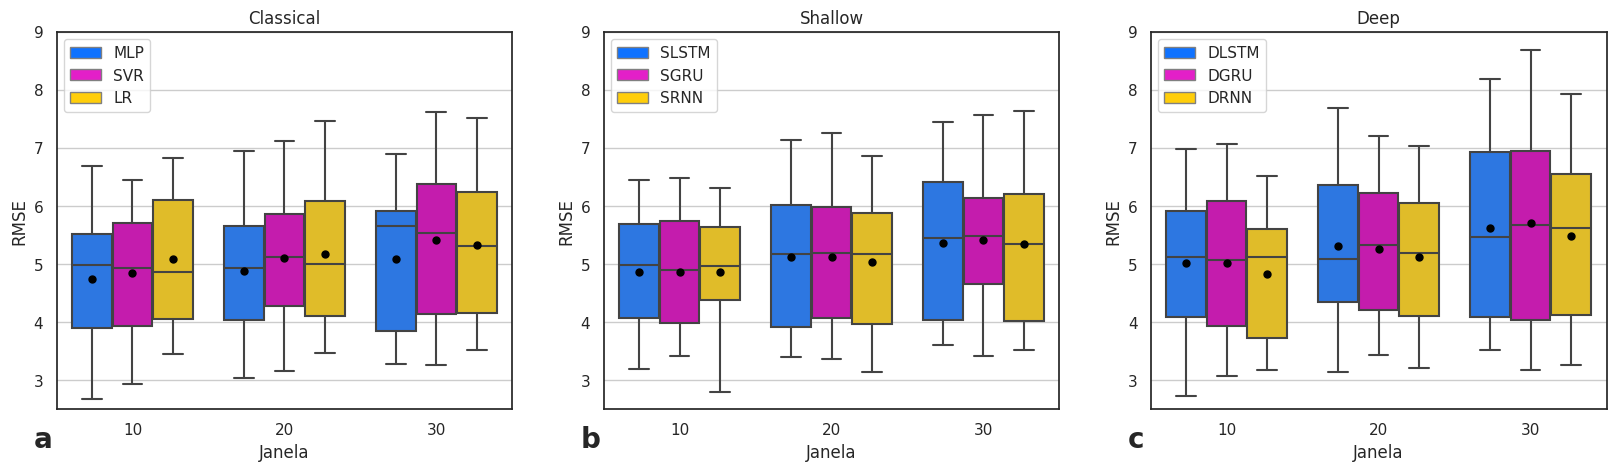

In [ ]:
#Importação e BoxPlot dos melhores modelos
import matplotlib.patches as mpatches
cod_falha = 35
sns.set_theme(style="white", palette=None)
fig = plt.figure(figsize = (20,5),dpi=100)
axes = gridspec.GridSpec(nrows=1, ncols=3, figure=fig, wspace=0.2, hspace=0.3)

im = ['a','b','c']
count=0

for model_type in ["classical", "shallow", "deep"]:
  best_models = get_best_models(model_type, cod_falha)
  best_models['Combinação'] = best_models ["Normalização"] +'+'+ best_models ["Modelo"]

  ax = fig.add_subplot(axes[count])
  ax.grid()
  
  sns.boxplot(data = best_models, y='RMSE',x='Janela',hue='Modelo', palette = colors1,
              showmeans=True,meanprops={"marker":".", "markerfacecolor":"black", 
                        "markeredgecolor":"black", "markersize":"10"})
  ax.text(-0.05, -0.1, im[count], size=20, weight='bold', transform=ax.transAxes)
  if model_type == "shallow":
    ax.set_title("Shallow")
    labels = ['SLSTM', 'SGRU', 'SRNN']
  elif model_type == "deep":
    ax.set_title("Deep")
    labels = ['DLSTM', 'DGRU', 'DRNN']
  else: 
    ax.set_title("Classical")
    labels = ['MLP', 'SVR', 'LR']

  pop_a = mpatches.Patch(facecolor=colors1[0], label=labels[0], edgecolor='gray')
  pop_b = mpatches.Patch(facecolor=colors1[1], label=labels[1], edgecolor='gray')
  pop_c = mpatches.Patch(facecolor=colors1[2], label=labels[2], edgecolor='gray')
  plt.legend(handles=[pop_a,pop_b,pop_c], loc='upper left', ncol=1)
  ax.set_ylim(2.5,9)
  count+=1
plt.savefig('resultados/fig_results_grid_f'+str(cod_falha)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

In [ ]:
#Concatenando todos os melhores resultados de cada tipo de modelo
cod_falha = 35
best_models_mean = pd.DataFrame()
for model_type in ["classical", "shallow", "deep"]:
  best_models = get_best_models(model_type, cod_falha)

  mean= best_models.groupby(['Modelo','Normalização', 'Parâmetros', "Janela"]).mean().round(decimals=3).astype(str)
  std = best_models.groupby(['Modelo','Normalização', 'Parâmetros', "Janela"]).std().round(decimals=3).astype(str)

  mean_std = mean +'('+ std  +")"
  mean_std = mean_std.reset_index()[['Modelo',"Normalização",'Janela',"RMSE","Parâmetros"]] #"MaxE","MAE","R2",

  mean_std = mean_std [mean_std.Janela==10]
  if model_type == "shallow":
    mean_std['Modelo'] = "S"+mean_std['Modelo']
  elif model_type == "deep":
    mean_std['Modelo'] = "D"+mean_std['Modelo']
  else:
    mean_std['Modelo'] = "C"+mean_std['Modelo']

  best_models_mean = pd.concat([best_models_mean, mean_std])

# print(mean_std.to_latex(index=False))

best_models_mean["Parâmetros"] = best_models_mean["Parâmetros"].apply(lambda row: np.char.replace(row, 'linearregression__', ""))
best_models_mean["Parâmetros"] = best_models_mean["Parâmetros"].apply(lambda row: np.char.replace(row, 'mlpregressor__', ""))
best_models_mean["Parâmetros"] = best_models_mean["Parâmetros"].apply(lambda row: np.char.replace(row, 'svr__', ""))
# best_models_mean["Parâmetros"].values

## Resultado para as aeronaves de teste

In [ ]:
#Visualização desgaste esperado vs. desgaste predito
def plot_results(y_test, y_pred, air_test):
  rmse = mean_squared_error(y_test, y_pred, squared = False)
  plt.figure(dpi=100,figsize=(20,4))
  plt.plot(y_test,':ok')
  plt.plot(y_pred,'-xm')
  plt.title("Aeronave: "+ str(int(air_test))+' | RMSE='+str(round(rmse,3)))
  plt.xlabel("Dias")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  # plt.xticks(rotation=90)
 
  # plt.ylim([0,80])

### Tratamento e separação x, y

In [ ]:
def final_split (data, data_test, best_models_mean, cod_falha, model_name):
  look_back= best_models_mean[best_models_mean.Modelo==model_name]["Janela"].values[0]

  norm = best_models_mean[best_models_mean.Modelo==model_name]["Normalização"].values[0]

  samples,_ = get_samples (data,cod_falha=cod_falha, look_back= look_back)
  samples_test, test_days = get_samples (data_test,cod_falha=cod_falha, look_back= look_back)
  x_test, y_test = split_train_test(samples_test, air_test=False, look_back=look_back, norm_method = False, reshape=False)

  if model_name[0] == "C":
    reshape=False
  else: 
    reshape=True
  
  x_train, y_train, y_scaler, x_scaler = split_train_test(samples,air_test=False, look_back=look_back, norm_method = norm, reshape=reshape)
  
  x_test =  x_scaler.transform(x_test)
  # y_test =  y_scaler.transform(y_test.reshape(-1,1))
  
  if reshape == True:
    x_test  = np.reshape(x_test, (x_test.shape[0], 1, x_test[0].shape[0]))
  # y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  return x_train, y_train, x_test, y_test, y_scaler, samples_test, test_days

### Retreino dos melhores modelos 

In [ ]:
cod_falha=35
look_back= 20
# model_name= "CMLP"

def retrain_model(data, data_test, cod_falha, best_models_mean):
  results = []
  for model_name in np.unique(best_models_mean.Modelo):
    look_back= best_models_mean[best_models_mean.Modelo==model_name]["Janela"].values[0]
    x_train, y_train, x_test, y_test, y_scaler, samples_test, test_days = final_split (data, data_test, best_models_mean, cod_falha, model_name)
    parameters = literal_eval (best_models_mean[best_models_mean.Modelo==model_name]["Parâmetros"].values[0])

    if model_name[0] != "C":
      n_recurr = parameters['Recurrent']
      n_dense = parameters['Dense']
      dropout = parameters['Dropout']
      l2 = parameters['L2']

    if model_name[0] == "S":
      model = shallow_model (model_name[1:], n_recurr, n_dense, dropout, l2, look_back)
    elif model_name[0] == "D":
      model = deep_model (model_name[1:], n_recurr, n_dense, dropout, l2, look_back)
    else:
      model = classical_model(model_name[1:], parameters)

    if model_name[0] != "C":
      early_stopping = EarlyStopping(patience=5)
      model.compile(loss='mean_squared_error', optimizer='adam')
      model.fit(x_train, y_train, epochs=400, batch_size=170, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      #revertendo a normalização e realizando a predição
      y_pred_rev = y_scaler.inverse_transform(model.predict(x_test)[:,0].reshape(-1,1))
    else:
      model.fit(x_train, y_train)
      #revertendo a normalização e realizando a predição
      y_pred_rev = y_scaler.inverse_transform(model.predict(x_test).reshape(-1,1))

    if model_name == "CMLP":
      y_test_return = y_test.copy()
      y_pred_return = y_pred_rev.copy()
    
    result = metrics(y_test[0:-1],y_pred_rev[0:-1])
    result.append(model_name)
    results.append(result)
  
  #modelo ingênuo (repete o último dia da janela)
  y_pred_= x_test[:,0,9]
  y_pred_= y_scaler.inverse_transform(y_pred_.reshape(-1,1))
  result = metrics(y_test[0:-1],y_pred_[0:-1])
  result.append("Ingênuo")
  results.append(result)

  #cria o dataframe com os resultados
  data_results = pd.DataFrame(results, columns= ['RMSE', 'MSE', 'MaxE', 'MAE', "R2",'Modelo'])

  return data_results, y_pred_return, y_test_return, y_pred_, samples_test, test_days 

data_results, y_pred_rev, y_test, y_pred_, samples_test, test_days = retrain_model(data, data_test, cod_falha, best_models_mean)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



26/26 [==============================] - 0s 2ms/step


In [ ]:
data_results.head(18)

,RMSE,MSE,MaxE,MAE,R2,Modelo
0,3.429208,11.759464,25.230355,2.316773,0.826044,CLR
1,2.943949,8.666833,19.381543,2.040132,0.871793,CMLP
2,2.970567,8.824267,22.253336,2.103390,0.869464,CSVR
3,3.192575,10.192533,21.994819,2.362400,0.849223,DGRU
4,3.047743,9.288740,22.161506,1.924197,0.862593,DLSTM
5,3.079563,9.483708,20.952575,2.229438,0.859709,DRNN
6,3.282926,10.777605,24.112159,2.043911,0.840568,SGRU
7,3.524266,12.420452,22.733047,2.480859,0.816266,SLSTM
8,3.190081,10.176617,23.841567,1.907433,0.849459,SRNN
9,3.739845,13.986442,30.328125,2.048521,0.793101,Ingênuo


In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2404, 20) (2404, 1) (353, 20) (814,)


## Plot Real x Previsto do melhor modelo

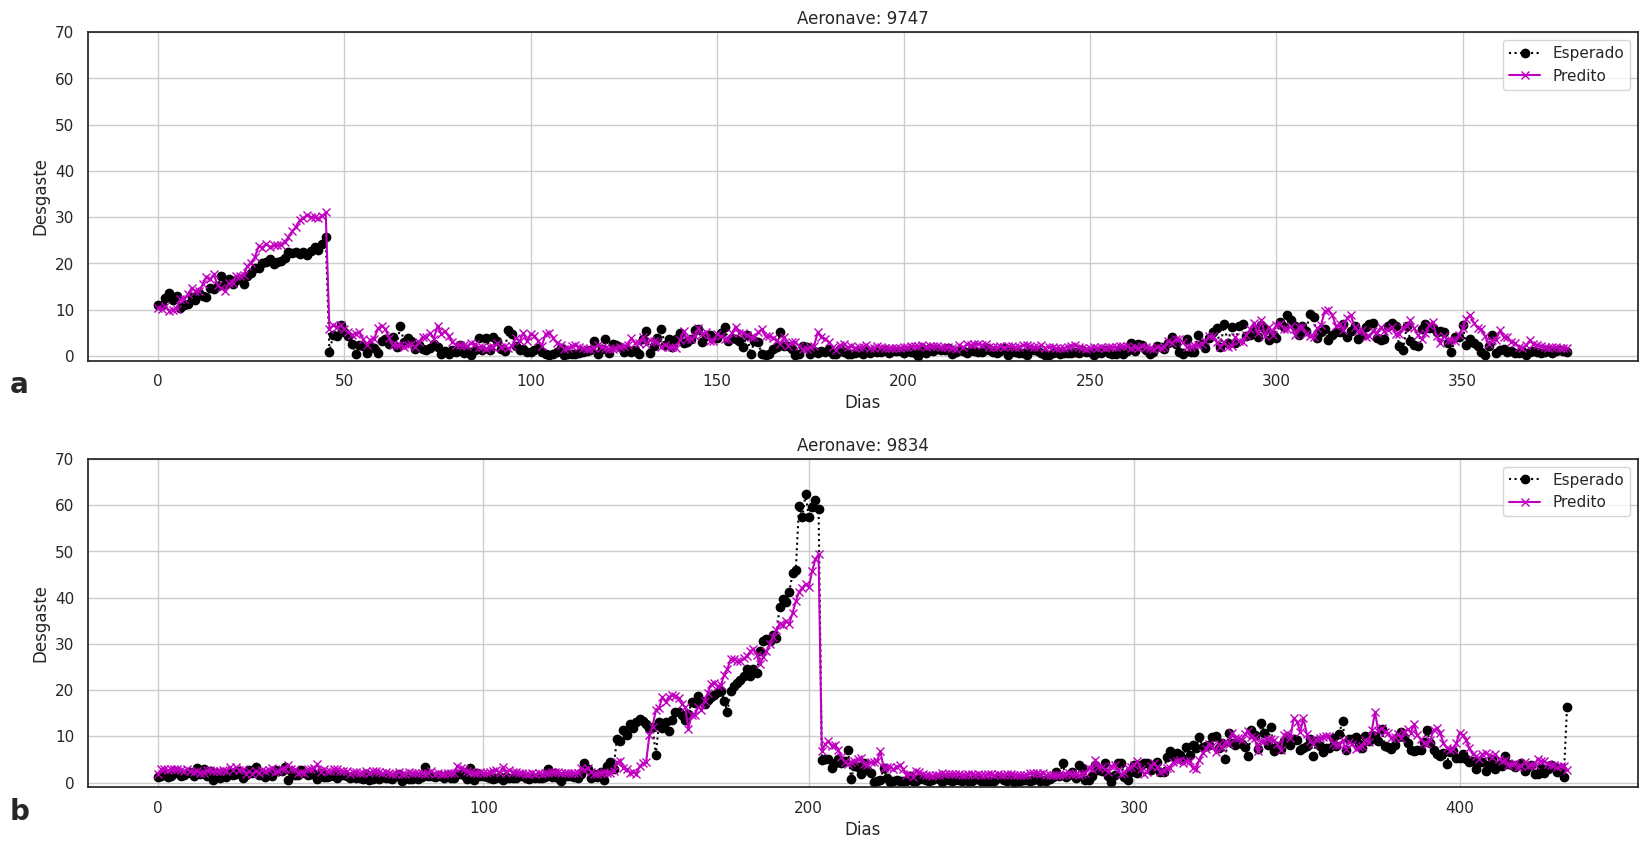

In [ ]:
# plot_results(y_test,y_pred_rev,air_test=00)
# plt.vlines(discontinuity_filt(y_test), 0, 100)

look_back= 10
np.diff(samples_test[:,look_back+10])

count = 0
for i in np.diff(samples_test[:,look_back+10]):
  # print (i)
  if i !=0:
    indice = count
  count = count+1

ind1 = [0,indice]

days = test_days[:,look_back+9]


days_=[]
for i in range(0,len(days)):

  if i%100 == 0:
   days_.append(days[i]) 
  
  else:
    days_.append('')

fig = plt.figure(figsize = (20,10),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, wspace=0.2, hspace=0.3)
im = ['a','b']

#plot do melhor modelo (9747)
ax = fig.add_subplot(axes[0])
ax.set_title("Aeronave: "+str(test[1]))
ax.grid()
ax.text(-0.05, -0.1, im[0], size=20, weight='bold', transform=ax.transAxes)
ax.plot(y_test[0:indice],':ok')
ax.plot(y_pred_rev[0:indice],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

#plot do melhor modelo (9834)
ax = fig.add_subplot(axes[1])
ax.set_title("Aeronave: "+str(test[0]))
ax.grid()
ax.text(-0.05, -0.1, im[1], size=20, weight='bold', transform=ax.transAxes)
ax.plot(y_test[indice:-1],':ok')
ax.plot(y_pred_rev[indice:-1],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

plt.savefig('resultados/fig_results_predict_f'+str(cod_falha)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

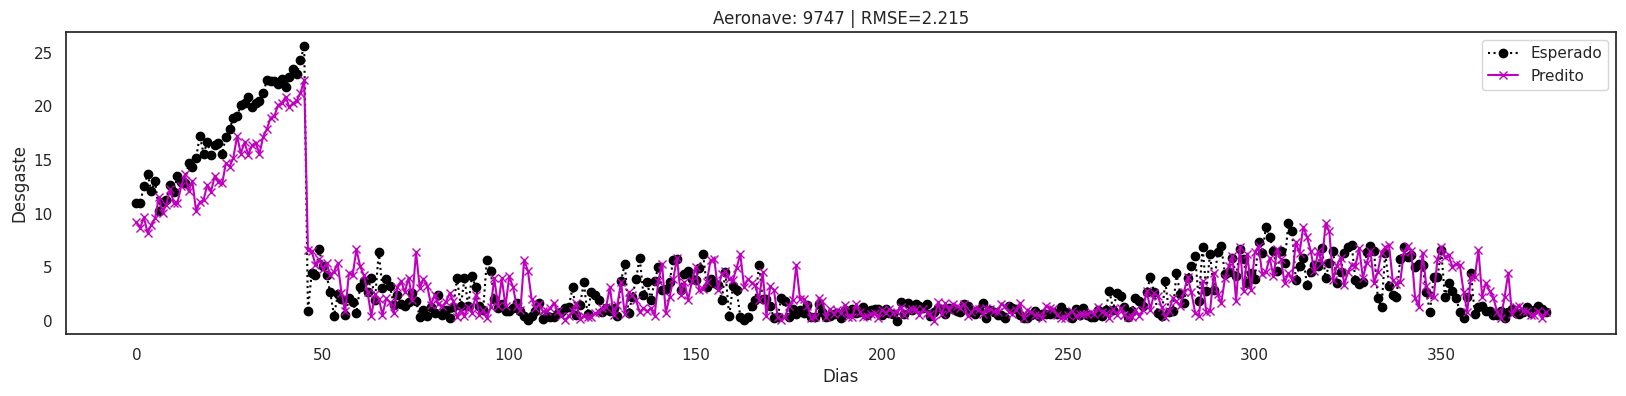

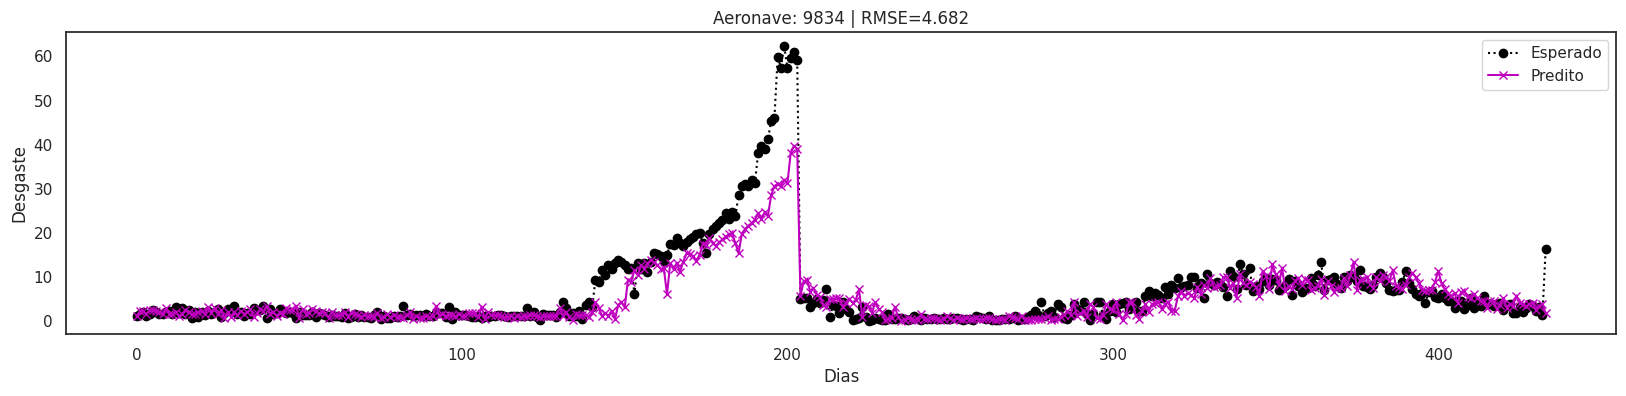

In [ ]:
#plot do modelo ingênuo (9747)
plot_results(y_test[0:indice], y_pred_[0:indice], test[1])
#plot do modelo ingênuo (9834)
plot_results(y_test[indice:-1], y_pred_[indice:-1], test[0])

In [ ]:
px.line(data_test, x='DT_PROC', y='VLR_DESG', color='COD_AENV', line_dash='COD_FALH')

In [ ]:
y_pred_ = x_test

In [ ]:
print(x_test[:,0,9].shape)

(814,)
